### **Model Training Process**

**Objective**: The goal of this process is to train a machine learning model that can accurately predict the target variable. During this phase, we will select the appropriate model, tune hyperparameters, and evaluate performance using cross-validation and relevant metrics. Additionally, we will handle data splitting into training and testing sets, implement regularization if necessary, and track performance to ensure the model generalizes well to unseen data

##### **First Step:** Import libraries and load data

In [185]:
# Importing libraries
import joblib
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle

# Load the processed data
df = pd.read_csv("../data/processed/MLA_100k_cleaned.csv")

---

##### **Second Step:** Choosing variables and separating sets

In [186]:
X = df[[
    'base_price',
    'price',
    'last_update',
    'accepts_mercadopago',
    'initial_quantity',
    'sold_quantity',
    'available_quantity']]

y = df['condition'].apply(lambda x: 1 if x == 'new' else 0)  # 1 = new, 0 = used

In [187]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

---

##### **Third Step:** List of models and training

In [188]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBBoost': XGBClassifier(eval_metric='logloss')
}

In [189]:
# Train and evaluate models
for name, model in models.items():
    print(f'Training the {name} model')
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Para AUC ROC
    
    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract metrics from the classification report for classes 0 and 1
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']
    
    # Create a temporary DataFrame with the current results
    temp_df = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'AUC-ROC': [auc_roc],
        'Precision_0': [precision_0],
        'Recall_0': [recall_0],
        'F1_0': [f1_0],
        'Precision_1': [precision_1],
        'Recall_1': [recall_1],
        'F1_1': [f1_1]
    })
    
    # Filter the temporary DataFrame to remove empty or all NA entries
    temp_df = temp_df.dropna(how='all', axis=1)
    
    # Contatenate the temporary DataFrame with the main DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)


Training the Random Forest model
Training the Gradient Boosting model
Training the K-Nearest Neighbors model
Training the Logistic Regression model
Training the XGBBoost model


---

##### **Fourth step:** Metrics review and choice of best model

*Let's make bar charts to see the metrics that we obtained*

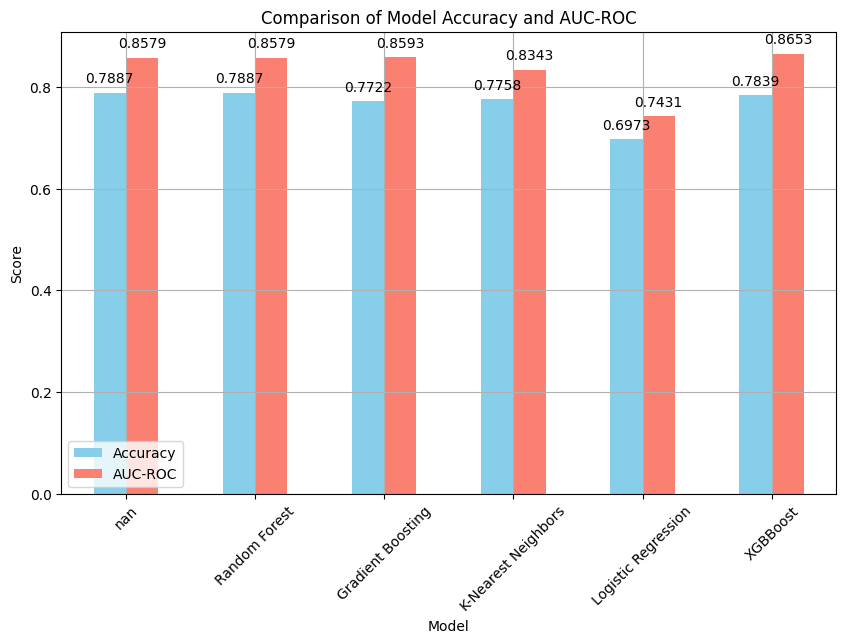

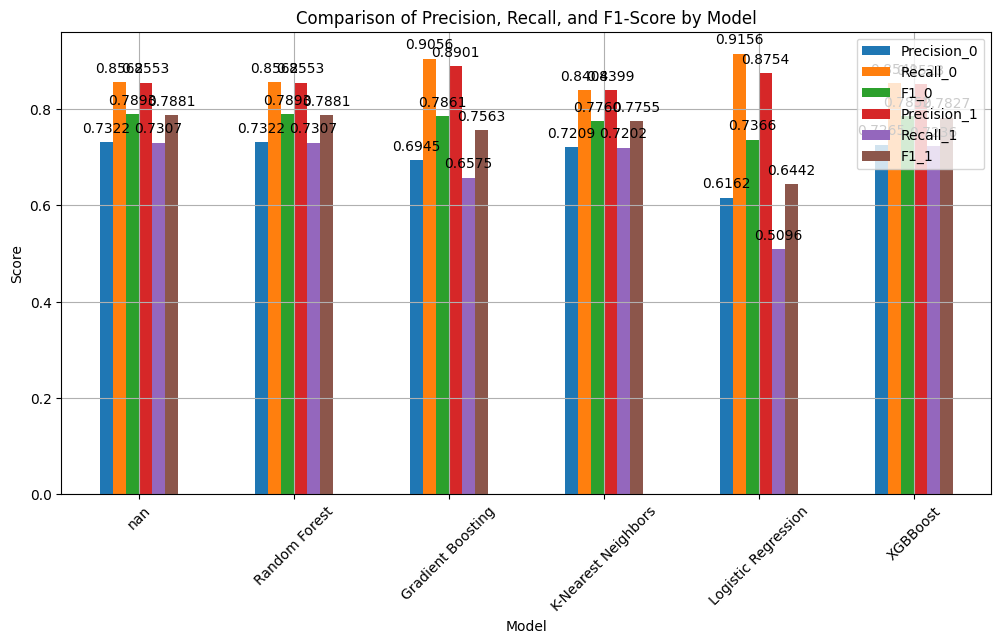

In [190]:
# Ensure that the index is unique for the models
results_df = results_df.reset_index(drop=True).drop_duplicates(subset='Model').set_index('Model')


# 1. Bar chart for Accuracy and AUC-ROC
fig, ax = plt.subplots(figsize=(10, 6))
bar_plot = results_df[['Accuracy', 'AUC-ROC']].plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])

# Title and labels
plt.title('Comparison of Model Accuracy and AUC-ROC')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)

# Add text labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), 
                        textcoords='offset points')

plt.show()

# 2. Multiple bar chart for Precision, Recall, and F1-Score
metrics = ['Precision_0', 'Recall_0', 'F1_0', 'Precision_1', 'Recall_1', 'F1_1']

fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = results_df[metrics].plot(kind='bar', ax=ax)

# Title and labels
plt.title('Comparison of Precision, Recall, and F1-Score by Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(True)

# Add text labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), 
                        textcoords='offset points')

plt.show()

#### **Fifth Step**: Export the best model as pkl

In [191]:
# Create the XGBoost model again
xgboost_model = XGBClassifier(eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# Save the model to disk
path = '../artifacts/models/model.pkl'
with open(path, 'wb') as f:
    pickle.dump(xgboost_model, f)

print(f"Succesfully saved XGBoost model to {path}")

Succesfully saved XGBoost model to ../artifacts/models/model.pkl


---

#### **Conclusions**

##### **First Graph: Accuracy and AUC-ROC comparison**
* XGBoost has the highest accuracy (0.8653) and a high AUC-ROC (0.7839). This positions it as the best model overall, outperforming even 2. Gradient Boosting in both metrics.
* Gradient Boosting and Random Forest have similar accuracy (0.8593 and 0.8579, respectively), but Gradient Boosting has a slightly lower AUC-ROC (0.7722).
* istic Regression remains the worst model in terms of accuracy (0.6973) and AUC-ROC (0.7431).

##### **Second Graph: Precision, Recall and F1-Score Comparison**
* XGBoost stands out in this graph as well, with high Precision, Recall and F1 values for both classes. It is notable that it has the highest F1-Score in the positive class (F1_1 = 0.7366), which is crucial in problems where the positive class is more relevant.
* Gradient Boosting remains a strong contender, with an F1_1 of 0.7563, although its Recall for the positive class (0.6575) is lower than that of XGBoost, meaning that XGBoost is better at capturing the positive class.
* Random Forest and K-Nearest Neighbors have similar metrics, but their F1 for the positive class is lower than Gradient Boosting and XGBoost, which puts them behind in this case.
* Logistic Regression continues to show problems in the positive class, with a low F1_1 (0.6442) and Recall (0.5096), indicating that it is less effective at correctly detecting the positive class.

#### **Final Decision**

XGBoost is the preferred model due to its excellent balance between overall accuracy, cross-class discrimination capability (AUC-ROC), and positive class performance (F1-Score and Recall), outperforming all other models in a context where these metrics are key.

---